# Imports

In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from src import *

%autoreload 2

# Signal

In [3]:
# Signal width
N = 128

# Sparse signal parameters
sparse_range = (-6, 6)
density = 0.005

# Smooth signal parameters
smooth_amplitude = 2
sigmas_range = (2e-2, 2e-1)
nb_gaussian = int(0.5 * N)

# Seed
seed = 42

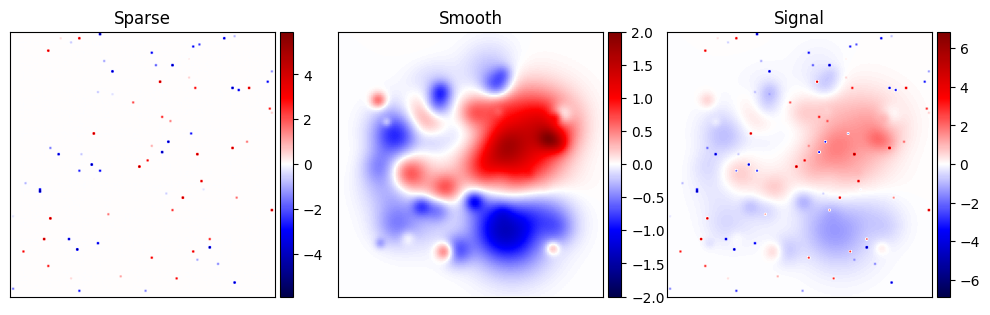

In [4]:
sparse_signal = compute_sparse(N, sparse_range, density, seed)
smooth_signal = compute_smooth(N, smooth_amplitude, sigmas_range, nb_gaussian, seed)

signal = sparse_signal + smooth_signal

plot_signal(sparse_signal, smooth_signal)

# Operator $\phi$

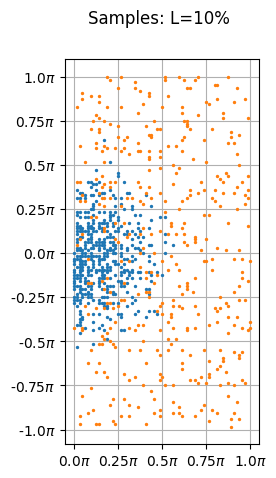

In [5]:
L = 0.1
theta = 0.5
op = NuFFT(N, L, theta, on_grid=True, seed=seed)

x0 = signal.reshape(-1)
y0 = op(x0)

psnr = 50
y = compute_y(y0, psnr)

op.plot_samples()

# Solver

In [6]:
from pyxu.operator import Laplacian
import time

# Loss weights
lambda1 = 1e-2
lambda2 = 5e-2

### Coupled

In [7]:
coupled = True
t0 = time.time()
x1, x2 = solve(y, op, lambda1, lambda2, coupled, Laplacian((op.N,op.N)))
t1 = time.time()

C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-12-04 14:51:18.553020] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-12-04 14:51:54.600572] Iteration 500
	iteration: 500
	N_iter: 501.0
	RelError[x]: 0.0006598558460327351
INFO -- [2023-12-04 14:52:31.622517] Iteration 1_000
	iteration: 1000
	N_iter: 1001.0
	RelError[x]: 0.00019646920687921163
INFO -- [2023-12-04 14:53:09.224909] Iteration 1_500
	iteration: 1500
	N_iter: 1501.0
	RelError[x]: 0.0001508751556773734
INFO -- [2023-12-04 14:53:46.652767] Iteration 2_000
	iteration: 2000
	N_iter: 2001.0
	RelError[x]: 0.00012484395886744893
INFO -- [2023-12-04 14:54:24.201303] Iteration 2_500
	iteration: 2500
	N_iter: 2501.0
	RelError[x]: 0.0001116759599757189
INFO -- [2023-12-04 14:55:01.749839] Iteration 3_000
	iteration: 3000
	N_iter: 3001.0
	RelError[x]: 0.00010566280996563805
INFO -- [2023-12-04 14:55:39.343255] Iteration 3_500
	iteration: 3500
	N_iter: 3501.0
	RelError[x]: 0.0001011974343224708
INFO -- [2023-12-04 14:55:49.128075] Iteration 3_627


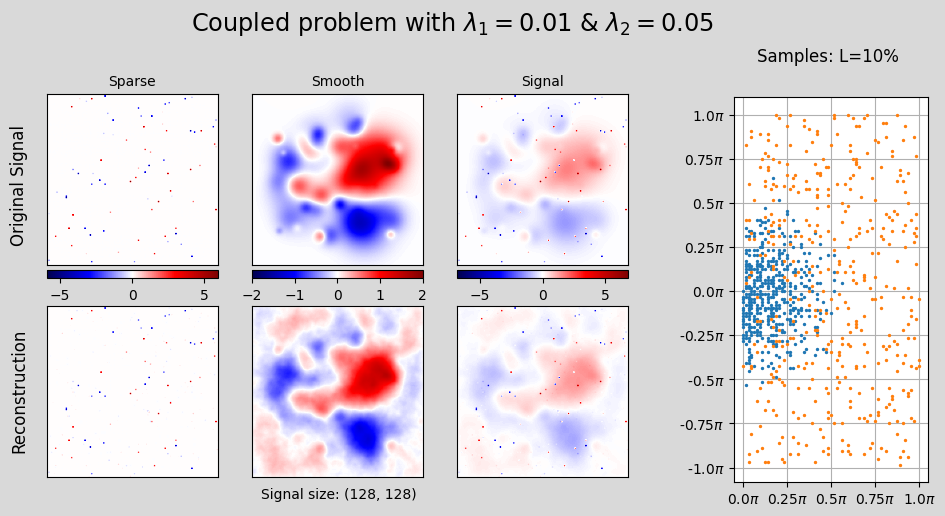

Button(description='SAVE', style=ButtonStyle())

Output()

In [8]:
sparse_rcstr, smooth_rcstr, signal_rcstr = map(
    lambda x: x.reshape((N,N)), (x1, x2, x1 + x2)
)

fig = plot_results(
    [sparse_signal, smooth_signal],
    [sparse_rcstr, smooth_rcstr],
    lambda1,
    lambda2,
    op,
    coupled,
)

save_widget(fig, lambda1, lambda2, op, psnr, coupled)

### Decoupled

In [9]:
coupled = False
t0 = time.time()
x1_, x2_ = solve(y, op, lambda1, lambda2, coupled, Laplacian((op.N,op.N)))
t1 = time.time()

1701698153.0136802
check id 0.03789925575256348
Co-Gram Identity
compute l2 op 5061.923019170761


C:\Users\costa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyxu\abc\arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


compute lip 5071.027800321579
compute l1 5071.028531551361
INFO -- [2023-12-04 16:20:24.044333] Iteration 0
	iteration: 0
	N_iter: 1.0
	RelError[x]: 0.0
INFO -- [2023-12-04 16:20:27.080483] Iteration 201
	iteration: 201
	N_iter: 202.0
	RelError[x]: 9.62221983523167e-05
INFO -- [2023-12-04 16:20:27.080483] Stopping Criterion satisfied -> END
solve x1 5074.0697956085205
compute x2 5078.453374385834


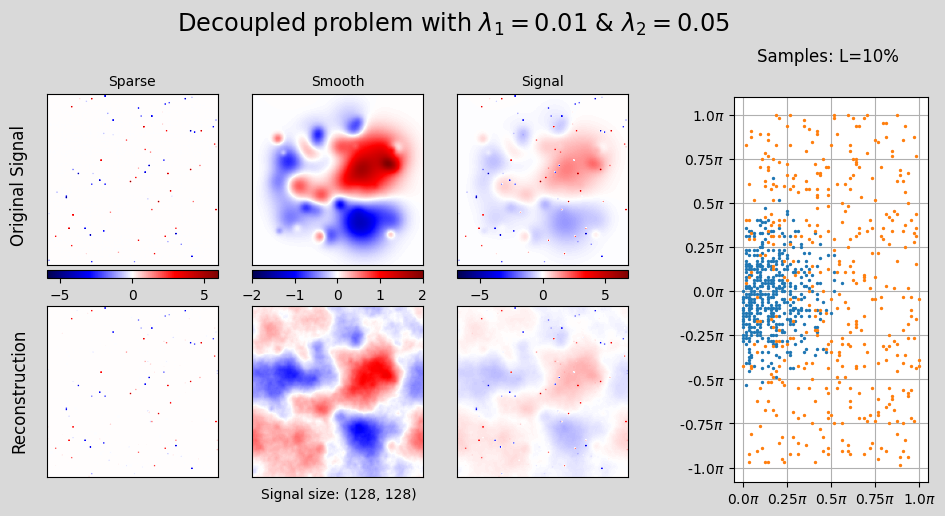

Button(description='SAVE', style=ButtonStyle())

Output()

In [10]:
sparse_rcstr_, smooth_rcstr_, signal_rcstr_ = map(
    lambda x: x.reshape((N,N)), (x1_, x2_, x1_ + x2_)
)

fig = plot_results(
    [sparse_signal, smooth_signal],
    [sparse_rcstr_, smooth_rcstr_],
    lambda1,
    lambda2,
    op,
    coupled,
)

save_widget(fig, lambda1, lambda2, op, psnr, coupled)

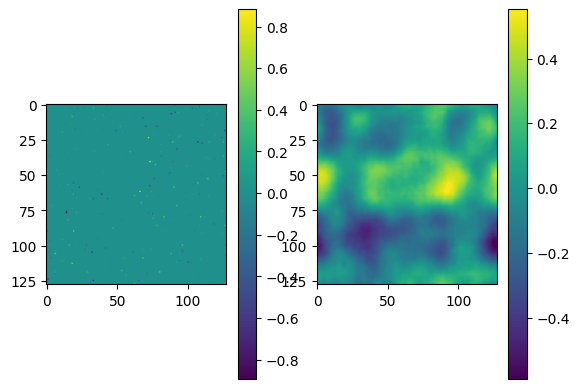

In [11]:
plt.subplot(121)
plt.imshow(sparse_rcstr - sparse_rcstr_)
plt.colorbar()
plt.subplot(122)
plt.imshow(smooth_rcstr - smooth_rcstr_)
plt.colorbar()

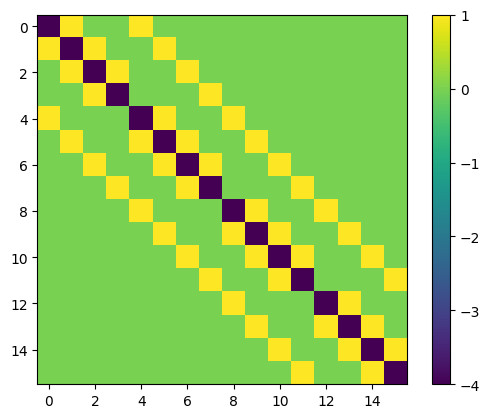

In [12]:
plt.imshow(Laplacian((4,4)).asarray())
plt.colorbar()